## Setup

In [607]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
import xgboost as xgb
import random
import importlib


In [610]:

importlib.reload(cleansing)

<module 'cleansing' from 'C:\\Users\\Joanna\\Documents\\GitHub\\epc-recc-analysis\\cleansing.py'>

In [5]:
# %conda install sklearn

## Data import

In [587]:
# choose to load example files or all files
example_files = False 
how_many_files = 12 #there are still files missing

In [588]:
#RUN
# read all sample files into memory
try: 
    del(df_cert)
    del(df_rec)
except:
    pass

files_counter = 0

if example_files:
    path = 'data_samples'
else:
    path = 'data_full'
    

for f in random.sample(os.listdir(path),how_many_files):
    
    print(f'Processing {f}')
    
    # Certificates files
    df_cert_temp = pd.read_csv(
        f'{path}/{f}/certificates.csv', 
        dtype = {'INSPECTION_DATE':'str','LODGEMENT_DATE':'str'},
        parse_dates=['INSPECTION_DATE','LODGEMENT_DATE'],
        low_memory=False
    )
    try:
        df_cert = pd.concat([df_cert, df_cert_temp])
    except:
         df_cert = df_cert_temp.copy()
        
    # Recommendations files
    df_rec_temp = pd.read_csv(f'{path}/{f}/recommendations.csv', low_memory=False)
    try:
        df_rec = pd.concat([df_rec, df_rec_temp])
    except:
        df_rec = df_rec_temp.copy()
        
    print(f'Length certificates: {len(df_cert)}, Length recommendations: {len(df_rec)}')
    
    files_counter += 1
    
df_cert.reset_index(inplace=True)
df_rec.reset_index(inplace=True)

Processing domestic-E07000039-South-Derbyshire
Length certificates: 37863, Length recommendations: 157730
Processing domestic-E09000018-Hounslow
Length certificates: 128638, Length recommendations: 450669
Processing domestic-E09000008-Croydon
Length certificates: 272018, Length recommendations: 960339
Processing domestic-E06000017-Rutland
Length certificates: 286418, Length recommendations: 1025240
Processing domestic-E07000235-Malvern-Hills
Length certificates: 317274, Length recommendations: 1165443
Processing domestic-E07000199-Tamworth
Length certificates: 342892, Length recommendations: 1275834
Processing domestic-E09000010-Enfield
Length certificates: 460410, Length recommendations: 1738850
Processing domestic-E07000144-Broadland
Length certificates: 505480, Length recommendations: 1948704
Processing domestic-E08000034-Kirklees
Length certificates: 659641, Length recommendations: 2617487
Processing domestic-E07000141-South-Kesteven
Length certificates: 720075, Length recommendati

In [591]:
#RUN
# create copy
cert = df_cert.copy() 

#lower case all col headers to speed up typing
cert.columns = [col.lower() for col in cert.columns]

## Cleansing NaNs

Quick cleanse to replace dubious labels with Nan.
Will do proper categories cleanse later.

In [ ]:
cert = cleansing.cleanse_nas(cert)

## Initial clean up of categorical variables

Quick clean up - will do a more thorough job further down 

#### PROPERTY_TYPE

In [ ]:
#RUN
#just drop the Park Homes
cert = cert.drop(cert[cert.property_type=='Park home'].index)
cert.property_type.isna().sum()

#### BUILT_FORM

In [ ]:
#RUN
#remove 'enclosed' from the terraced properties 

cert.built_form = cert.built_form.map({
    'Enclosed End-Terrace':'End-Terrace',
    'Enclosed Mid-Terrace':'Mid-Terrace',
    'Mid-Terrace':'Mid-Terrace',
    'Semi-Detached':'Semi-Detached',
    'End-Terrace':'End-Terrace',
    'Detached':'Detached'
})

cert.built_form.value_counts()

#### ENERGY_TARIFF

In [ ]:
#RUN
#replace the unknowns with actual NAs

cert['energy_tariff'] = cert.energy_tariff.replace('Unknown',np.nan)

cert.energy_tariff.value_counts()

#### GLAZED_TYPE

In [ ]:
#RUN
#remap these messy categories 
cert.glazed_type = cert.glazed_type.replace(
    ['double, known data','secondary glazing'],'double glazing, unknown install date')
cert.glazed_type = cert.glazed_type.replace('triple, known data','triple glazing')

cert.glazed_type = cert.glazed_type.replace(['INVALID!','not defined'],np.nan)

cert.glazed_type.value_counts()

#### TENURE

In [ ]:
#RUN
cert.tenure = cert.tenure.replace('unknown',np.nan)
cert.tenure = cert.tenure.replace('Not defined.*',np.nan,regex=True)
cert.tenure = cert.tenure.replace('Rented (social)','rental (social)')
cert.tenure = cert.tenure.replace('Rented (private)','rental (private)')
cert.tenure = cert.tenure.replace('Owner-occupied','owner-occupied')

cert.tenure.value_counts()

## Impute w/in same building 
Fill in NaNs if there is more than one certificate w/in the same building, where the attribute was populated at least once. Assumes attribute is time-invariant.

TODO: add flag for inputation to be used in the model?

In [ ]:
fill_columns = ['built_form',
 'mains_gas_flag',
 'floor_level',
 'number_habitable_rooms',
 'roof_description',
 'heat_loss_corridor',
 'floor_height']

In [ ]:
for col in fill_columns:
    
    print(f'Filling {col}')
    
    temp = cert[['building_reference_number','lmk_key',col]].groupby('building_reference_number').count()
    temp = temp[
        (temp.lmk_key>1)& #more than one certificate on the same building
        (temp[col]>0)& #at least one certificate with attribute populated
        (temp[col]<temp.lmk_key) #at least one certificate where attribute missing  
    ]
    
    print(f'Filling in missing values for {len(temp)} properties')
    if len(temp)==0: continue
    
    # Get filler values
    temp_lookup = cert[cert.building_reference_number.isin(temp.index)].groupby('building_reference_number')[col].agg(
        lambda x: pd.Series.mode(x)[0]) #just get the most frequent
    
    #join original table to the lookup table to get the filler values
    temp_filler = cert.loc[cert.building_reference_number.isin(temp.index) & cert[col].isna()].merge(
        temp_lookup, how='left',left_on='building_reference_number',right_index=True)[col+'_y']

    # fill in original table 
    cert.loc[cert.building_reference_number.isin(temp.index) & cert[col].isna(),col
            ] = temp_filler
    

## Dedupe on same date
TODO: didn't do anything with this for now. Consider later.
Quite high % of duplicates (but they could be different apartments? we do not get the apartment number).

In [ ]:
len(cert[cert.duplicated(subset=['building_reference_number','inspection_date'])]) / len(cert)

In [ ]:
len(cert[cert.duplicated(subset=['uprn','inspection_date'])]) / len(cert)

## Dropping cols that are mostly empty

TODO: Check if worth replicating this.

Not doing it for now because will treat fields differently later on.

## Clipping values

TODO: review all of these thresholds - done using analysis from DSCampus

In [ ]:
def call_clip(df):
    
    ''' 
    Clips the variables of the EPC data between 0 and a specified upper amount
    '''
    
    df['current_energy_efficiency'].clip(lower = 0.0, upper = 100, inplace = True)
    df['energy_consumption_current'].clip(lower = 0.0, upper = 600, inplace = True)
    df['co2_emissions_current'].clip(lower = 0.0, upper = 20, inplace = True)
    df['co2_emiss_curr_per_floor_area'].clip(lower = 0.0, upper = 100, inplace = True)
    df['lighting_cost_current'].clip(lower = 0.0, upper = 150, inplace = True)
    df['heating_cost_current'].clip(lower = 0.0, upper = 1750, inplace = True)
    df['hot_water_cost_current'].clip(lower = 0.0, upper = 350, inplace = True)
    df['total_floor_area'].clip(lower = 10.0, upper = 175, inplace = True)
    df['multi_glaze_proportion'].clip(lower = 0.0, upper = 100, inplace = True)
    df['extension_count'].clip(lower = 0.0, upper = 4, inplace = True)
    df['number_habitable_rooms'].clip(lower = 0.0, upper = 10, inplace = True)
    df['number_heated_rooms'].clip(lower = 0.0, upper = 9, inplace = True)
    df['low_energy_lighting'].clip(lower = 0.0, upper = 100, inplace = True)
    df['number_open_fireplaces'].clip(lower = 0.0, upper = 4, inplace = True)
    df['floor_height'].clip(lower = 0.0, upper = 3, inplace = True)
    return(df)

call_clip = call_clip(cert)


## Strings cleanup 

A lot of string manipulation to clean up fields (taken mostly from DSCampus analysis).

Might not be necessary if we do not end up using the relevant variables.

#### Remove bi-lingual sentences

In [ ]:
descriptive_columns = ['floor_description',
 'lighting_description',
 'roof_description',
 'walls_description',
 'windows_description',
 'hotwater_description',
 'main_heating_controls']

for col in descriptive_columns:
    cert[col] = cert[col].str.replace(r"\|(.*)","",regex=True)

#### Cleaning up units for average thermal transmittance

In [ ]:
def thermal_cleanup(df):
    
    ''' 
    standardising the wording in the variables containing average thermal transmittance. Specifically, 
    removing bi-lingual versions, removing =, translating welsh version, and standardising units
    '''
    
    for c in ['floor_description','walls_description','roof_description']:
        df[c] = df[c].str.replace('  ',' ')
        df[c] = df[c].str.replace('Average thermal transmittance 1 ','Average thermal transmittance 1.00 ')
        df[c] = df[c].str.replace('Average thermal transmittance =','Average thermal transmittance')
        df[c] = df[c].str.replace('Trawsyriannedd thermol cyfartalog','Average thermal transmittance')
        # standardising the unit used
        df[c] = df[c].str.replace(r"W(.*?)K",'W/m²K',regex=True)
        
    return df

cert = thermal_cleanup(cert)

#### Floor description

In [ ]:
def thermal_floor(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field to 1 decimal place
    '''
    
    # finds the decimal number
    df['floors_average_thermal_transmittance'] = df['floor_description'].str.findall(r'\d.\d*')
    # rounds the number to 1 decimal place
    df['floors_average_thermal_transmittance'] = round(df['floors_average_thermal_transmittance'].str[0].astype(float),1)
    # 
    df['floor_description'] = df.apply(lambda row: 'average thermal transmittance %.1f W/m²K' % (row['floors_average_thermal_transmittance']) if 'Average' in str(row['floor_description']) else row['floor_description'],axis=1)
    
    return df

cert = thermal_floor(cert)

In [ ]:
def floor_cleanup(df):
    
    ''' 
    cleans-up the floor_description feature from the EPC dataset
    '''
    
    df['floor_description'] = df['floor_description'].str.lower()

    # translating welsh sentences
    df['floor_description'] = df['floor_description'].str.replace(r"anheddiad arall islaw",'another dwelling below') 
    df['floor_description'] = df['floor_description'].str.replace("\(eiddo arall islaw\)",'other premises below') 
    df['floor_description'] = df['floor_description'].str.replace(r"wedi(.*?)i inswleiddio","insulated")
    df['floor_description'] = df['floor_description'].str.replace("dim inswleiddio","no insulation")
    df['floor_description'] = df['floor_description'].str.replace("(rhagdybiaeth)","assumed")
    df['floor_description'] = df['floor_description'].str.replace("crog","suspended")
    df['floor_description'] = df['floor_description'].str.replace("heb ei inswleiddio","no insulation")
    df['floor_description'] = df['floor_description'].str.replace("i ofod heb ei wresogi","to unheated space")
    df['floor_description'] = df['floor_description'].str.replace("solet","solid")
    df['floor_description'] = df['floor_description'].str.replace("inswleiddio cyfyngedig","limited insulation")

    # removing assumed
    df['floor_description'] = df['floor_description'].str.replace("\(assumed\)","")

    # standardising language
    df['floor_description'] = df['floor_description'].str.replace("\(another dwelling below\)",'other premises below') 
    df['floor_description'] = df['floor_description'].str.replace("\(other premises below\)",'other premises below')
    df['floor_description'] = df['floor_description'].str.replace("solid.",'solid,') 
    df['floor_description'] = df['floor_description'].str.replace("uninsulated",'no insulation,') 
    df['floor_description'] = df['floor_description'].str.replace("insulation=100mm",'100 mm insulation') 
    df['floor_description'] = df['floor_description'].str.replace(", \(assumed\)",' (assumed)')
    df['floor_description'] = df['floor_description'].str.replace("insulation=25mm",'25 mm insulation')
    df['floor_description'] = df['floor_description'].str.replace("insulation=75mm",'75 mm insulation')
    df['floor_description'] = df['floor_description'].str.replace("limited insulated",'limited insulation')
    # cleanup
    df['floor_description'] = df['floor_description'].str.replace("[ \t]+$","")
    df['floor_description'] = df['floor_description'].str.replace(r'\,$','')
    df['floor_description'] = df['floor_description'].str.replace(r'^, ','')
    df['floor_description'] = df['floor_description'].str.replace(r'\?','')
    
    return df

cert = floor_cleanup(cert)

#### Lighting description

In [ ]:
# lighting and second heat descriptions have some entries the wrong way around
cert['secondheat_description1'] = cert.apply(
    lambda row: row['lighting_description'] if 'lighting' in str(row['secondheat_description']) else row['secondheat_description'],axis = 1)
cert['lighting_description1'] = cert.apply(
    lambda row: row['secondheat_description'] if 'lighting' in str(row['secondheat_description']) else row['lighting_description'],axis = 1)

cert.drop(columns= ['secondheat_description','lighting_description'],axis=1,inplace=True)
cert.rename(columns={'secondheat_description1':'secondheat_description','lighting_description1':'lighting_description'},inplace=True)

In [ ]:
def lighting_cleanup(df):
    
    ''' 
    cleans-up the lighting_description feature from the EPC dataset
    '''
    
    df['lighting_description'] = df['lighting_description'].str.lower()
    # combining ways of saying all lights are low energy
    df['lighting_description'] = df['lighting_description'].str.replace(r'goleuadau ynni-isel ym mhob un o.r mannau gosod','low energy lighting in all fixed outlets')
    df['lighting_description'] = df['lighting_description'].str.replace(r'low energy lighting in 120% of fixed outlets','low energy lighting in all fixed outlets')
    df['lighting_description'] = df['lighting_description'].str.replace(r'low energy lighting 100% of fixed outlets','low energy lighting in all fixed outlets')
    # translating welsh sentences
    df['lighting_description'] = df['lighting_description'].str.replace(r"\|goleuadau(.*)",'') 
    df['lighting_description'] = df['lighting_description'].str.replace(r"o.r mannau gosod",'of fixed outlets')
    df['lighting_description'] = df['lighting_description'].str.replace('% fixed','% of fixed')
    df['lighting_description'] = df['lighting_description'].str.replace('goleuadau ynni-isel mewn','low energy lighting in')
    df['lighting_description'] = df['lighting_description'].str.replace(r"\.\d*",'')
    df['lighting_description'] = df['lighting_description'].str.replace("dim goleuadau ynni-isel",'no low energy lighting')
    # clean up
    df['lighting_description'] = df['lighting_description'].str.replace("eneregy",'energy')
    
    return df

cert = lighting_cleanup(cert)



In [ ]:
def lighting_perc_cleanup(df):
    
    ''' 
    rounds the low energy lighting percentage figure which is within a str field
    '''
    
    df['low_energy_lighting_perc'] = df['lighting_description'].str.findall(r'(\d*)\%')
    df['low_energy_lighting_perc'] = round(df['low_energy_lighting_perc'].str[0].astype(float),-1)
    df['lighting_description'] = df.apply(lambda row: 'low energy lighting %d%% of fixed outlets' % (int(row['low_energy_lighting_perc'])) if '%' in str(row['lighting_description']) else row['lighting_description'],axis=1)

    return df

cert = lighting_perc_cleanup(cert)

#### Roof description

In [ ]:
def roof_cleanup(df):
    
    ''' 
    cleans-up the roof_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'roof_description'
    Returns a dataframe 
    '''
    
    # standardising units
    df['roof_description'] = df['roof_description'].str.replace(" mm",'mm')
    df['roof_description'] = df['roof_description'].str.replace(">= 300mm",">=300mm")
    df['roof_description'] = df['roof_description'].str.replace(">=300mm","300+mm")
    # translating welsh sentences
    df['roof_description'] = df['roof_description'].str.replace("\|\(eiddo arall uwchben\)","")
    df['roof_description'] = df['roof_description'].str.replace("Ar oleddf","Pitched")
    df['roof_description'] = df['roof_description'].str.replace("dim inswleiddio","no insulation")
    df['roof_description'] = df['roof_description'].str.replace(r"wedi(.*?)i inswleiddio","insulated")
    df['roof_description'] = df['roof_description'].str.replace("(rhagdybiaeth)","assumed")
    df['roof_description'] = df['roof_description'].str.replace(r"lo inswleiddio yn y llof.*","loft insulation")
    df['roof_description'] = df['roof_description'].str.replace(r"o inswleiddio yn y llof.*","loft insulation")
    df['roof_description'] = df['roof_description'].str.replace("Ystafell\(oedd\) to","Roof room(s)")
    df['roof_description'] = df['roof_description'].str.replace(r"wedi(.*?)i hinswleiddio","insulated")
    df['roof_description'] = df['roof_description'].str.replace("nenfwd","ceiling")
    df['roof_description'] = df['roof_description'].str.replace("wrth y trawstia(.*?)","at rafters")
    df['roof_description'] = df['roof_description'].str.replace("inswleiddio cyfyngedig","limited insulation")
    df['roof_description'] = df['roof_description'].str.replace("To gwellt, gydag inswleiddio ychwanegol","Thatched, with additional insulation")
    df['roof_description'] = df['roof_description'].str.replace("Yn wastad","Always")
    # standardising descriptions
    df['roof_description'] = df['roof_description'].str.replace("Roof room,","Roof room(s),")
    df['roof_description'] = df['roof_description'].str.replace("annedd arall uwchben","other premises above")
    df['roof_description'] = df['roof_description'].str.replace("another dwelling above","other premises above")
    df['roof_description'] = df['roof_description'].str.replace("Dwelling Above","(other premises above)")
    df['roof_description'] = df['roof_description'].str.replace(r"0 W/m²K",r" W/m²K")
    df['roof_description'] = df['roof_description'].str.replace("  W/m²K"," 0.0 W/m²K")
    df['roof_description'] = df['roof_description'].str.replace("Roof room\(s\), no insulation\(assumed\)","Roof room(s), no insulation (assumed)")
    df['roof_description'] = df['roof_description'].str.replace("Other premises above","(other premises above)")
    df['roof_description'] = df['roof_description'].str.replace("\(assumed\)","")
    # cleanup
    df['roof_description'] = df['roof_description'].str.replace(r'\.$','')
    df['roof_description'] = df['roof_description'].str.replace(r'\,$','')
    df['roof_description'] = df['roof_description'].str.replace("  \+"," +")
    df['roof_description'] = df['roof_description'].str.replace("[ \t]+$","")
    df['roof_description'] = df['roof_description'].str.replace("mmmm","mm")
    df['roof_description'] = df['roof_description'].str.replace("Thatchedinsulated","Thatched, insulated")
    df['roof_description'] = df['roof_description'].str.replace("\*\*\* INVALID INPUT Code \: 57 \*\*\*","")
    
    return df

cert = roof_cleanup(cert)

In [ ]:
def thermal_roof(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field
    '''
    
    df['roof_average_thermal_transmittance'] = df['roof_description'].str.findall(r'(\d.\d*) W/m²K')
    df['roof_average_thermal_transmittance'] = round(df['roof_average_thermal_transmittance'].str[0].astype(float),1)
    df['roof_description'] = df.apply(lambda row: 'average thermal transmittance %.1f w/m²k' % (row['roof_average_thermal_transmittance']) if 'Average' in str(row['roof_description']) else row['roof_description'],axis=1)
    
    return df

cert = thermal_roof(cert)

#### Walls description

In [437]:
def walls_cleanup(df): 
    
    ''' 
    cleans-up the walls_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'walls_description'
    Returns a dataframe 
    '''
    
    # removing phrases like as built which aren't adding anything
    df['walls_description'] = df['walls_description'].str.lower()
    df['walls_description'] = df['walls_description'].str.replace(r"fel y(.*?)u hadeiladwyd, ","")
    df['walls_description'] = df['walls_description'].str.replace("as built, ","")
    df['walls_description'] = df['walls_description'].str.replace("cavity\.","cavity wall,")
    df['walls_description'] = df['walls_description'].str.replace("\(rhagdybiaeth\)","(assumed)")
    df['walls_description'] = df['walls_description'].str.replace("\(assumed\)","")
    # translating welsh sentences
    df['walls_description'] = df['walls_description'].str.replace("waliau ceudod","cavity wall")
    df['walls_description'] = df['walls_description'].str.replace("dim inswleiddio","no insulation")
    df['walls_description'] = df['walls_description'].str.replace("tywodfaen","sandstone")
    df['walls_description'] = df['walls_description'].str.replace("ceudod wedi(.*?)i lenwi","filled cavity")
    df['walls_description'] = df['walls_description'].str.replace(r"wedi(.*?)u hinswleiddio","insulated")
    df['walls_description'] = df['walls_description'].str.replace(r"ffr(.*?)m bren","timber frame")
    df['walls_description'] = df['walls_description'].str.replace("briciau solet","solid brick")
    df['walls_description'] = df['walls_description'].str.replace("wedi(.*?)u hadeiladu yn (.*?)l system","system built")
    df['walls_description'] = df['walls_description'].str.replace("inswleiddio rhannol","partial insulation")
    df['walls_description'] = df['walls_description'].str.replace("gydag inswleiddio allanol","with external insulation")
    df['walls_description'] = df['walls_description'].str.replace("gwenithfaen neu risgraig","granite or whinstone")
    df['walls_description'] = df['walls_description'].str.replace("gydag inswleiddio mewnol","with internal insulation")
    # standardising punctuation
    df['walls_description'] = df['walls_description'].str.replace("solid brick\.","solid brick,")
    # standardising language
    df['walls_description'] = df['walls_description'].str.replace("granite or whin,","granite or whinstone,")
    df['walls_description'] = df['walls_description'].str.replace("stone \(granite or whin\)\.","granite or whinstone,")
    df['walls_description'] = df['walls_description'].str.replace("with external insulation","insulated")
    df['walls_description'] = df['walls_description'].str.replace("with internal insulation","insulated")
    df['walls_description'] = df['walls_description'].str.replace("with additional insulation","insulated")
    df['walls_description'] = df['walls_description'].str.replace("with insulation","insulated")
    # clean up
    df['walls_description'] = df['walls_description'].str.replace(r'\.$','')
    df['walls_description'] = df['walls_description'].str.replace('\+ chr\(13\) \+','+')
    df['walls_description'] = df['walls_description'].str.replace("  \+"," +")
    df['walls_description'] = df['walls_description'].str.replace("[ \t]+$","")
    df['walls_description'] = df['walls_description'].str.replace('timber frame\.','timber frame,')
    df['walls_description'] = df['walls_description'].str.replace('\?','')
    df['walls_description'] = df['walls_description'].str.replace('system built\.','system built,')
    
    return df

cert = walls_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace(r"fel y(.*?)u hadeiladwyd, ","")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace("cavity\.","cavity wall,")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace("\(rhagdybiaeth\)","(assumed)")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2908878170.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['walls_description'] = df['walls_description'].str.replace(

In [438]:
def thermal_walls(df):
    
    ''' 
    rounds the average thermal transmittance figure which is within a str field
    '''
    
    df['walls_average_thermal_transmittance'] = df['walls_description'].str.findall(r'\d.\d\d')
    df['walls_average_thermal_transmittance'] = round(df['walls_average_thermal_transmittance'].str[0].astype(float),1)
    df['walls_description'] = df.apply(lambda row: 'average thermal transmittance %.1f w/m²k' % (row['walls_average_thermal_transmittance']) if 'average' in str(row['walls_description']) else row['walls_description'],axis=1)
    
    return df

cert = thermal_walls(cert)

#### Windows description

In [439]:
def windows_cleanup(df): 
    
    ''' 
    cleans-up the windows_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'windows_description'
    Returns a dataframe 
    '''
    
    df['windows_description'] = df['windows_description'].str.lower()
    # translating welsh sentences
    df['windows_description'] = df['windows_description'].str.replace("ffenestri perfformiad uchel","high performance glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau dwbl gan mwyaf","mostly double glazing")
    df['windows_description'] = df['windows_description'].str.replace("rhai gwydrau dwbl","partial double glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau sengl","single glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau dwbl rhannol","partial double glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau dwbl llawn","fully double glazing")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau lluosog ym mhobman","multiple glazing throughout")
    df['windows_description'] = df['windows_description'].str.replace("gwydrau eilaidd llawn","full secondary glazing")
    # standardising language
    df['windows_description'] = df['windows_description'].str.replace("glazed","glazing")
    df['windows_description'] = df['windows_description'].str.replace("fully","full")
    df['windows_description'] = df['windows_description'].str.replace("fully","full")
    # cleanup
    df['windows_description'] = df['windows_description'].str.replace("single glazingsingle glazing","single glazing")
    df['windows_description'] = df['windows_description'].str.replace("single glazingdouble glazing","single glazing and double glazing")
    df['windows_description'] = df['windows_description'].str.replace("single glazingsecondary glazing","single glazing and secondary glazing")
    df['windows_description'] = df['windows_description'].str.replace("[ \t]+$","")
    df['windows_description'] = df['windows_description'].str.replace("  "," ")
    
    return df

cert = windows_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3119369361.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['windows_description'] = df['windows_description'].str.replace("[ \t]+$","")


#### Hotwater description

In [440]:
def hotwater_cleanup(df):
    
    ''' 
    cleans-up the hotwater_description feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'hotwater_description'
    Returns a dataframe 
    '''
    
    # removing spaces at the end
    df['hotwater_description'] = df['hotwater_description'].str.replace("[ \t]+$","")

    # translating welsh sentences
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"O(.*?)r brif system","From main system")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Trochi trydan","Electric immersion")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"an-frig","off-peak")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"O system eilaidd","From secondary system")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Nwy wrth fwy nag un pwynt","Gas multipoint")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Popty estynedig olew","Oil range cooker")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"tarriff safonol","standard tariff")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Dim system ar gael","No system present")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"adfer gwres nwyon ffliw","flue gas heat recovery")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"gydag ynni(.*?)r haul","plus solar")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"dim thermostat ar y silindr","no cylinderstat")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"rhagdybir bod twymwr tanddwr trydan","electric immersion assumed")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"an-frig","off peak")
    df['hotwater_description'] = df['hotwater_description'].str.replace(r"Twymwr tanddwr","underfloor heating")

    # standardising language
    df['hotwater_description'] = df['hotwater_description'].str.replace("cylinder thermostat","cylinderstat")
    df['hotwater_description'] = df['hotwater_description'].str.replace("No system present :","No system present:")
    df['hotwater_description'] = df['hotwater_description'].str.replace("No hot water system present -","No system present:")
    df['hotwater_description'] = df['hotwater_description'].str.replace("From community scheme","Community scheme")
    df['hotwater_description'] = df['hotwater_description'].str.replace("Community heat pump","Community scheme with CHP")
    df['hotwater_description'] = df['hotwater_description'].str.replace("From secondary heater","From secondary system")
    df['hotwater_description'] = df['hotwater_description'].str.replace("SAP05:Hot-Water","SAP:Hot-Water")
    df['hotwater_description'] = df['hotwater_description'].str.replace("community scheme","Community scheme")
    df['hotwater_description'] = df['hotwater_description'].str.replace("plus solar, no cylinderstat","no cylinderstat, plus solar")
    df['hotwater_description'] = df['hotwater_description'].str.replace("From second main heating system","From secondary system")
    df['hotwater_description'] = df['hotwater_description'].str.replace("none","No system present: electric immersion assumed")
    df['hotwater_description'] = df['hotwater_description'].str.replace("plus solar, flue gas heat recovery","flue gas heat recovery, plus solar")
    df['hotwater_description'] = df['hotwater_description'].str.replace("no cylinderstat, no cylinderstat","no cylinderstat")

    # cleanup
    df['hotwater_description'] = df['hotwater_description'].str.replace("No system present\?electric immersion assumed","No system present: electric immersion assumed")
    df['hotwater_description'] = df['hotwater_description'].replace("***SAMPLE***",np.nan)

    return df

cert = hotwater_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwater_description'].str.replace("[ \t]+$","")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwater_description'].str.replace(r"O(.*?)r brif system","From main system")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwater_description'].str.replace(r"gydag ynni(.*?)r haul","plus solar")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\3908772556.py:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df['hotwater_description'] = df['hotwate

#### Main heating controls

In [441]:
def heat_control_cleanup(df):
    
    ''' 
    cleans-up the main_heating_controls feature from the EPC dataset
    Parameters
      df: a dataframe containing a variable called 'main_heating_controls'
    Returns a dataframe 
    '''
    
    df['main_heating_controls'] = df['main_heating_controls'].str.lower()

    # translating welsh sentences
    df['main_heating_controls'] = df['main_heating_controls'].str.replace(r"rheoli.r t.l . llaw","manual charge control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd, dim thermostat ystafell","programmer, no room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rheolaeth amser a rheolaeth parthau tymheredd","time and temperature zone control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd a thermostat ystafell","programmer and room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd a thermostatau ar y cyfarpar","programmer and appliance thermostats")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd ac o leiaf ddau thermostat ystafell","programmer and at least two room thermostats")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostat ystafell yn unig","room thermostat only")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("dim rheolaeth thermostatig ar dymheredd yr ystafell","no thermostatic control of room temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rheoli gwefr drydanol yn awtomatig","automatic charge control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("dim rheolaeth amser na rheolaeth thermostatig ar dymheredd yr ystafell","no time or thermostatic control of room temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("trvs a falf osgoi","trvs and bypass")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("rhaglennydd","programmer")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("tal un gyfradd, thermostat ystafell yn unig","flat rate charging, room thermostat only")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostat ystafell a trvs","room thermostat and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("t(.*?)l un gyfradd","flat rate charging")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostatau ar y cyfarpar","appliance thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("dim","none")

    # standardising language
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer, no thermostat","programmer, no room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("flat rate charging\*","flat rate charging")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("\+","and")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("\&","and")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("trv.s","trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostats","thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("communit ","community ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("to the use of community heating","to use of community heating")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace(" stat"," thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("controls","control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("prog ","programmer ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("program ","programmer ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmerand","programmer and")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("delayed start thermostat and program and trvs","delayed start thermostat, program and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("thermostatic","thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("flat rate charging, programmer no room thermostat","flat rate charging, programmer, no room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace(" 2 "," two ")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("roomstat","room thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and room thermostat and trvs","programmer, room thermostat and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and trvs and boiler energy manager","programmer, trvs and boiler energy manager")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and trvs and bypass","programmer, trvs and bypass")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer and trvs and flow switch","programmer, trvs and flow switch")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("temp+$","temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("no thermostat control of room temperature","no thermostat control")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("appliance thermostat and programmer","programmer and appliance thermostat")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("delayed start thermostat and programmer and trvs","delayed start thermostat, programmer and trvs")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("no time or thermostat control of temperature","no time or thermostat control of room temperature")
    df['main_heating_controls'] = df['main_heating_controls'].str.replace("programmer\?and","programmer and")
  
    
    return df

cert = heat_control_cleanup(cert)

C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['main_heating_controls'] = df['main_heating_controls'].str.replace(r"rheoli.r t.l . llaw","manual charge control")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['main_heating_controls'] = df['main_heating_controls'].str.replace("t(.*?)l un gyfradd","flat rate charging")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['main_heating_controls'] = df['main_heating_controls'].str.replace("flat rate charging\*","flat rate charging")
C:\Users\Joanna\AppData\Local\Temp\ipykernel_13112\2782498958.py:34: FutureWarning: The default value of regex will change from True to False in a future versi

In [442]:
# this might have been dealt with already 
cert['transaction_type'] = cert['transaction_type'].str.replace(" - this is for backwards compatibility only and should not be used","")
cert['glazed_type'] = cert['glazed_type'].replace('INVALID!',np.nan)

## Proper clean up on categorical and numeric variables

This is still largely incomplete - only focussed on variables that are likely to be known by a user.

#### Floor level
Will create 2 variables - a variable with the floor number (where available), and another one with some rough classes (bottom, mid, top floors)

In [443]:
#TODO: check these
# cert.floor_level.value_counts()

In [444]:
# np.savetxt("floor_level_mapper.csv", cert.floor_level.unique(), delimiter=",", fmt='%s')

In [445]:
#prepare the mapper
floor_level_mapper = pd.read_csv('floor_level_mapper.csv')

keys = floor_level_mapper.iloc[:,0].values.tolist()
values1 = floor_level_mapper.iloc[:,1].values.tolist()
# values2 = floor_level_mapper.iloc[:,2].values.tolist()

floor_level_numeric_mapper = {k:v for (k,v) in zip(keys,values1)}
# floor_level_classes_mapper = {k:v for (k,v) in zip(keys,values2)}

In [446]:
# Map numeric
cert['floor_level_numeric'] = cert.floor_level.map(floor_level_numeric_mapper)
print(cert.floor_level_numeric.isna().sum(), cert.floor_level.isna().sum())
cert.floor_level_numeric.value_counts()

322984 314693


1.000     36140
0.000     33892
2.000     17804
3.000      6077
4.000      1737
-1.000     1355
5.000       847
6.000       387
7.000       292
10.000      215
8.000       213
9.000       187
11.000      149
12.000      125
14.000      111
13.000       98
15.000       49
16.000       40
17.000       13
21.000        2
Name: floor_level_numeric, dtype: int64

In [536]:
# cert.floor_level.isna().sum(), cert.floor_level_numeric.isna().sum()

In [447]:
# review these when dataset is complete
floor_level_dict = dict.fromkeys(['Ground','ground floor','Basement',],'ground floor')
floor_level_dict1 = dict.fromkeys(['1st','2nd','3rd','4th'],'low floors')
floor_level_dict2 = dict.fromkeys(['mid floor','5th','6th','7th','8th','9th','10th','11th'],'mid floors')
floor_level_dict3 = dict.fromkeys(['top floor','12th','13th','14th','15th','16th','17th','18th','19th','20th',
                                   '21st or above'],'top floors')
floor_level_dict4 = {
    '1st':'low floors',
    'Ground':'ground floor',
    '2nd':'low floors',
    '01':'low floors',
    '00':'ground floor',
    '3rd':'low floors',
    '02':'low floors',
    'ground floor':'ground floor',
    '1.0':'low floors',
    '0.0':'ground floor',
    '2.0':'low floors',
    '4th':'low floors',
    '03':'low floors',
    '3':'low floors',
    '1':'low floors',
    '2':'low floors',
    '0':'ground floor',
    '-1':'ground floor',
    'Basement':'ground floor'
}

floor_level_dict.update(floor_level_dict1)
floor_level_dict.update(floor_level_dict2)
floor_level_dict.update(floor_level_dict3)
floor_level_dict.update(floor_level_dict4)

cert['floor_level_classes'] = cert.floor_level.map(floor_level_dict)

print(cert.floor_level_classes.isna().sum())
cert.floor_level_classes.value_counts()



315143


low floors      61557
ground floor    35256
mid floors       6520
top floors       4241
Name: floor_level_classes, dtype: int64

#### Main Heating Controls

TODO: check this - the DSCampus analysis does use this, but does not seem to be the same field

In [538]:
cert.main_heating_controls.value_counts()[:20]

2106    79897
2104    32194
2107    21445
2401    10981
2102     6364
2402     2347
2601     2164
2602     2164
2103     1920
2101     1743
2603     1723
2111     1557
2307      987
2699      907
2105      748
2110      619
2504      458
2404      418
2305      367
2109      309
Name: main_heating_controls, dtype: int64

#### Hot Water Description

Taken from DSCampus analysis

In [449]:
def hotwater_types(df):

    df['hotwater_mains'] = df.apply(lambda row: 1 if 'from main system' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_immersion'] = df.apply(lambda row: 1 if 'immersion' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_commmunity'] = df.apply(lambda row: 1 if 'community' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_solar'] = df.apply(lambda row: 1 if 'solar' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_gas'] = df.apply(lambda row: 1 if 'gas' in str(row['hotwater_description']).lower() else 0,axis = 1)
    df['hotwater_recovery'] = df.apply(lambda row: 1 if 'recovery' in str(row['hotwater_description']).lower() else 0,axis = 1)

    return df

cert = hotwater_types(cert)

#### Windows description

3 fields: 'windows_description', 'windows_energy_eff', 'windows_env_eff'

Will only use the description for now - and it seems pretty much the same as 'glazed_type'

In [450]:
# Mark rare labels as 'other'
# todo: review this on the overall file
wd_counts = cert.windows_description.value_counts()
wd_rare = wd_counts[wd_counts <= 500].index
cert['windows_description'] = cert.windows_description.replace(wd_rare,'other')
cert.windows_description.value_counts()

full double glazing          323137
high performance glazing      32316
single glazing                21082
partial double glazing        18543
mostly double glazing         15816
some double glazing            5935
other                          1874
partial secondary glazing      1353
full secondary glazing         1345
full triple glazing             574
Name: windows_description, dtype: int64

#### Roof type

Will derive 2 0-1 features capturing if roof is pitched or flat

In [451]:
def roof_types(df):

    df['pitched_roof'] = df.apply(lambda row: 1 if 'pitched' in str(row['roof_description']).lower() else 0,axis = 1)
    df['flat_roof'] = df.apply(lambda row: 1 if 'flat' in str(row['roof_description']).lower() else 0,axis = 1)

    return df

cert = roof_types(cert)

#### Main heat

Will get rid of rare labels and use the rest as categories

In [452]:
# Mark rare labels as 'other'
# todo: review this on the overall file
mh_counts = cert.mainheat_description.value_counts()
mh_rare = mh_counts[mh_counts <= 100].index
cert['mainheat_description'] = cert.mainheat_description.replace(mh_rare,'other')
cert.mainheat_description.value_counts()

Boiler and radiators, mains gas                                                 332253
Electric storage heaters                                                         28857
Boiler and radiators, oil                                                        15726
Room heaters, electric                                                           12498
Community scheme                                                                  8283
Boiler and radiators, LPG                                                         3824
Boiler and underfloor heating, mains gas                                          2297
Boiler and radiators, electric                                                    2225
No system present: electric heaters assumed                                       1837
other                                                                             1816
Room heaters, mains gas                                                           1685
Air source heat pump, radiators, electric  

#### Main heating controls

Replace rare labels

In [453]:
# todo: review this on the overall file
mhc_counts = cert.mainheatcont_description.value_counts()
mhc_rare = mhc_counts[mhc_counts <= 100].index
cert['mainheatcont_description'] = cert.mainheatcont_description.replace(mhc_rare,'other')
cert.mainheatcont_description.value_counts()

Programmer, room thermostat and TRVs                                       199610
Programmer and room thermostat                                              73818
Programmer, TRVs and bypass                                                 42337
Time and temperature zone control                                           25565
Manual charge control                                                       22737
Programmer, no room thermostat                                              12532
Programmer and appliance thermostats                                         5845
Automatic charge control                                                     5274
Appliance thermostats                                                        4593
No thermostatic control of room temperature                                  4235
Room thermostat only                                                         3906
No time or thermostatic control of room temperature                          3088
Flat rate chargi

#### Main fuel

Created a manual mapper. TODO: review this when we have the full dataset

In [454]:
main_fuel_mapper = {
    'mains gas (not community)':'mains gas',
    'mains gas - this is for backwards compatibility only and should not be used':'mains gas',
    'electricity (not community)':'electricity',
    'electricity - this is for backwards compatibility only and should not be used':'electricity',
    'mains gas (community)':'mains gas (community)',
    'Gas: mains gas':'mains gas',
    'To be used only when there is no heating/hot-water system':'no heating/hot-water system',
    'oil (not community)':'oil', 
    'Electricity: electricity, unspecified tariff':'electricity',
    'LPG (not community)':'LPG', 
    'dual fuel - mineral + wood':'dual fuel - mineral + wood',
    'oil - this is for backwards compatibility only and should not be used':'oil',
    'house coal (not community)':'coal',
    'To be used only when there is no heating/hot-water system or data is from a community network':'no heating/hot-water system',
    'smokeless coal':'coal', 
    'wood logs':'wood',
    'LPG - this is for backwards compatibility only and should not be used':'LPG',
    'bottled LPG':'LPG', 
    'INVALID!':np.nan, 
    'bulk wood pellets':'pellets', 
    'electricity (community)':'electricity (community)'
}

cert['main_fuel'] = cert.main_fuel.map(main_fuel_mapper)


#### Wind turbine flag

In [455]:
cert['wind_turbine_flag'] = (cert.wind_turbine_count >= 1).astype(int)

#### Construction age band

This could be very important. Make sure it is properly mapped.

In [583]:
# # TODO: change this. Create 2 vars, one with the actual band and the other one as numeric (year of contruction)
# cert['construction_age_band'] = cert.construction_age_band.replace('INVALID!',np.nan)
# cert.construction_age_band.value_counts()

In [584]:
cert['construction_age_band'] = cert.apply(
    lambda r: r['construction_age_band'] 
    if 'England' in str(r['construction_age_band']) 
    else np.nan, axis=1)

cert.construction_age_band.value_counts().head(5)

England and Wales: 1950-1966      72106
England and Wales: 1967-1975      52865
England and Wales: before 1900    38210
England and Wales: 1900-1929      33775
England and Wales: 1930-1949      33382
Name: construction_age_band, dtype: int64

In [585]:
#create numeric
cert['construction_age_numeric'] = cert.apply(lambda row: int(row['construction_age_band'])
                                            if str(row['construction_age_band']).isdigit() 
                                            else np.nan,axis = 1)

cert.construction_age_numeric.value_counts().head(5)

Series([], Name: construction_age_numeric, dtype: int64)

## Recommendations file clean-up

Easier to cleanse, only a couple of steps

In [457]:
#copy
rec = df_rec.copy()

In [458]:
# lower case headers
rec.columns = [c.lower() for c in rec.columns]

In [459]:
len(df_rec), df_rec.IMPROVEMENT_ID.isna().sum(), df_rec.IMPROVEMENT_ID_TEXT.isna().sum()

(1811920, 174245, 174245)

#### Improvement id text

`improvement_summary_text` sometimes contains the label that should go into `improvement_id_text`, therefore will copy it over and assign the corresponding `improvement_id`

In [460]:
improv_descr_toreplace = rec.improvement_summary_text.loc[~rec.improvement_summary_text.isna()]
improv_descr_toreplace

378        Low energy lighting for all fixed outlets
379                              Solar water heating
380                Solar photovoltaic panels, 2.5kWp
5304       Low energy lighting for all fixed outlets
11134      Low energy lighting for all fixed outlets
                             ...                    
1781545           Solar photovoltaic panels, 2.5 kWp
1785390                          Solar water heating
1785391           Solar photovoltaic panels, 2.5 kWp
1790953                          Solar water heating
1790954           Solar photovoltaic panels, 2.5 kWp
Name: improvement_summary_text, Length: 1181, dtype: object

In [461]:
# run assignment
rec.loc[~rec.improvement_summary_text.isna(),'improvement_id_text'] = improv_descr_toreplace

In [462]:
# fix some spelling issue
rec.improvement_id_text = rec.improvement_id_text.replace(
    'Solar photovoltaic panels, 2.5kWp','Solar photovoltaic panels, 2.5 kWp',regex=False)

In [463]:
# now these cols will have taxt but not corresponding id
# fix that
text_to_assign = rec.loc[rec.improvement_id.isna() & ~rec.improvement_id_text.isna()].improvement_id_text.unique()
text_reassignment_mapper = rec.loc[
    rec.improvement_id_text.isin(text_to_assign)].groupby('improvement_id_text')['improvement_id'].max()

text_reassignment_mapper = pd.DataFrame(text_reassignment_mapper)

ids_to_replace = rec.loc[rec.improvement_id.isna() & ~rec.improvement_id_text.isna()].merge(
    text_reassignment_mapper,left_on='improvement_id_text',right_index=True).improvement_id_y

rec.loc[rec.improvement_id.isna() & ~rec.improvement_id_text.isna(), 'improvement_id'] = ids_to_replace

In [464]:
#fix some more spelling issues
rec.improvement_id_text = rec.improvement_id_text.replace({
    'Upgrading heating controls':'Upgrade heating controls',
    'Replace heating unit with mains gas condensing unit':'Replace heating unit with condensing unit'},
    regex=False)


#### Improvement ids

Some ids have the same text. That means they represent the same type of improvement. As such they should be treated as the same class.

TODO: more work can be done to infer improvement id from `improvement_descr_text`

In [465]:
rec.groupby(['improvement_id_text','improvement_id'])['lmk_key'].count()

improvement_id_text                                              improvement_id
50 mm internal or external wall insulation                       7.000              75054
Add additional 80 mm jacket to hot water cylinder                3.000              17020
Cavity wall insulation                                           6.000              87054
Change heating to gas condensing boiler                          27.000              2009
                                                                 29.000              2606
                                                                 32.000                98
Change room heaters to condensing boiler                         40.000              1621
                                                                 41.000                92
Condensing oil boiler with radiators                             28.000                15
                                                                 43.000                12
Draughtproof single-

In [466]:
#when multiple IDs are assigned to the same text description, just choose one of them 
#for all (so we reduce the number of classes)

text_to_id_mapper = rec.groupby('improvement_id_text')['improvement_id'].min()
text_to_id_mapper = pd.DataFrame(text_to_id_mapper)

improvement_id_toreplace = rec.merge(
    text_to_id_mapper,how='left',left_on='improvement_id_text', right_index=True).improvement_id_y

rec.improvement_id = improvement_id_toreplace

In [467]:
# still many cases where id is null, for now will just drop those

rec.drop(rec.loc[rec.improvement_id.isna()].index,inplace=True)

## Final checks on cert and rec sets

In [468]:
# check that lmk key is unique 
cert.lmk_key.nunique() == len(cert)

True

In [469]:
# there are some certificates in cert that do not have any corresponding records in rec
len(cert), cert.lmk_key.isin(rec.lmk_key).sum()

(422717, 361514)

In [470]:
# get rid of certificates that do not have corresponding recommendations
cert.drop(cert[~cert.lmk_key.isin(rec.lmk_key)].index, inplace=True)


In [471]:
# also get rid of recommendations that do not have a corresponding certificate
len(rec), rec.lmk_key.isin(cert.lmk_key).sum()

(1638856, 1638004)

In [472]:
rec.drop(rec[~rec.lmk_key.isin(cert.lmk_key)].index, inplace=True)

In [473]:
# merge the sets
merged = cert.merge(rec, how='left', left_on='lmk_key', right_on='lmk_key')


In [474]:
# get an idea of how many recommendations per certificate
merged.groupby('lmk_key')['improvement_id'].count().value_counts() / len(cert)

4    0.173
5    0.164
3    0.146
6    0.133
2    0.133
7    0.085
1    0.070
8    0.052
9    0.023
10   0.013
11   0.004
12   0.003
14   0.001
16   0.000
13   0.000
18   0.000
20   0.000
22   0.000
24   0.000
15   0.000
Name: improvement_id, dtype: float64

In [475]:
# final check
len(merged), len(rec), merged.lmk_key.nunique(), cert.lmk_key.nunique(), rec.lmk_key.nunique()

(1638004, 1638004, 361514, 361514, 361514)

In [476]:
# get id to text mapper
id_to_text_mapper = rec.groupby('improvement_id').improvement_id_text.max()
id_to_text_mapper.head(5)

improvement_id
1.000        Insulate hot water cylinder with 80 mm jacket
2.000               Increase hot water cylinder insulation
3.000    Add additional 80 mm jacket to hot water cylinder
4.000                        Hot water cylinder thermostat
5.000                   Increase loft insulation to 270 mm
Name: improvement_id_text, dtype: object

In [477]:
# get counts of how many times each recommendation is used 
id_counts = pd.concat([rec.groupby('improvement_id')['lmk_key'].count(), 
           100*rec.groupby('improvement_id')['lmk_key'].count()/len(cert)],axis=1).merge(id_to_text_mapper,
                                                                                        left_on='improvement_id',
                                                                                        right_index=True)
id_counts.columns = ['vol','perc','text']
id_counts

,vol,perc,text
improvement_id,,,
1.000,2424,0.671,Insulate hot water cylinder with 80 mm jacket
2.000,22212,6.144,Increase hot water cylinder insulation
3.000,17008,4.705,Add additional 80 mm jacket to hot water cylinder
4.000,16978,4.696,Hot water cylinder thermostat
5.000,67938,18.793,Increase loft insulation to 270 mm
6.000,87054,24.080,Cavity wall insulation
7.000,74887,20.715,50 mm internal or external wall insulation
8.000,33125,9.163,Replace single glazed windows with low-E doubl...
9.000,738,0.204,Secondary glazing to single glazed windows


Some classes are too under-represented for the algo to learn anything significant (also run the risk of all samples ending up in train or test).

Will get rid of any under-represented class.

TODO: review threshold later on full dataset

In [478]:
min_count_class = 20

ids_to_delete = id_counts[id_counts.vol <= min_count_class].index

rec.drop(rec[rec.improvement_id.isin(ids_to_delete)].index,inplace=True)

In [479]:
# if this means there are certificates without at least one recommendation, then we should implement code to delete those too
# RUN THIS CHECK
len(cert) - cert.lmk_key.isin(rec.lmk_key).sum()

0

## Prepare train and test sets

#### X
Narrow down the set of variables, one-hot encode categoricals etc.

In [480]:
# take a copy of certificates
x = cert.copy()

In [481]:
# set the lmk key as the index
x.set_index('lmk_key',inplace=True)
x.sort_index(inplace=True)

In [482]:
# narrow down set of explanatory variables (see notes)
selected_vars = [
    'property_type', 
    'built_form', 
    'total_floor_area', 
    'energy_tariff', 
    'mains_gas_flag',
    'floor_level_numeric',
    'floor_level_classes',
    'flat_top_storey',
    'flat_storey_count',
    'multi_glaze_proportion', #doubt we will be able to get this from user!
    'glazed_type',
    'glazed_area', #doubt we will be able to get this from user!
    'extension_count',
    'number_habitable_rooms', #A! check this and the following - likely to be highly correlated
    'number_heated_rooms',
    'low_energy_lighting', #A! check this and the following - likely to be highly correlated
    'low_energy_lighting_perc', #this is a derived var
    'number_open_fireplaces', #doubt we will be able to get this from user!
    'hotwater_mains', #derived from the hotwater description - domain driven 
    'hotwater_immersion',
    'hotwater_commmunity',
    'hotwater_solar',
    'hotwater_gas',
    'hotwater_recovery',
    'hot_water_energy_eff', #doubt we will be able to get this from user!
    'hot_water_env_eff', #consider dropping - highly correlated
    'windows_description',
    'pitched_roof',
    'flat_roof',
    'mainheat_description',
    'mainheatcont_description', #doubt they will be able to provide this!
    'main_fuel', #doubt they will know 
    'wind_turbine_flag',
    'heat_loss_corridor', # need to see if they know 
    'floor_height',
    'solar_water_heating_flag',
    'mechanical_ventilation', # ?
    'construction_age_band',
    'tenure'
]

x = x[selected_vars]

In [483]:
# check the categoricals
cat_vars = [c for c in x.columns if x[c].dtype=='object']

# for c in cat_vars:
#     print(c)
#     print(x[c].nunique())

In [484]:
# check numeric vars
num_vars = [c for c in x.columns if x[c].dtype!='object']
# x[num_vars].describe()

In [485]:
# One-hot encode cat features
x = pd.get_dummies(x)

In [486]:
# save column names
all_vars = x.columns

#### y
Will need to create an input array of dims (n_samples, n_classes) to go into the multi-label classification. 

In [487]:
# Now prepare y

y = rec.copy()

In [488]:
tuples_improvements = y.groupby('lmk_key')['improvement_id'].apply(lambda x: tuple(x.values))

tuples_improvements = pd.DataFrame(tuples_improvements)

# A! turns out some sets of recommendations are duplicated within the same certificate. We only need to 
# retain one set for each certificate. The binarizer below already does that.

In [489]:
# sort y
tuples_improvements.sort_index(inplace=True)


(x.index == tuples_improvements.index).all()

True

In [490]:
# Initialize binarizer
mlb = MultiLabelBinarizer(classes=id_to_text_mapper.index)
y = mlb.fit_transform(tuples_improvements.values[:,0])
y.shape

(361514, 40)

#### Scaling X

In [491]:
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x.values)

#### Train/test split

In [492]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

## Training
### Single-class model

In [124]:
class_number = 1

y_train[:,class_number].sum(), len(y_train) #choose improvement in position 23

(10388, 192376)

In [125]:
id_to_text_mapper.iloc[class_number]

'Increase hot water cylinder insulation'

In [126]:
xgb_cl = xgb.XGBRFClassifier(n_estimators=50)

xgb_cl.fit(x_train, y_train[:,class_number])#, eval_metrix='logloss')

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', max_bin=256, max_cat_threshold=64,
                max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
                max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=50, n_jobs=0,
                num_parallel_tree=50, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0, ...)

In [293]:
tmp = pd.concat([pd.Series(all_vars),pd.Series(100*xgb_cl.feature_importances_/xgb_cl.feature_importances_.sum())],axis=1
         )
tmp.columns = ['name','weight']
tmp.sort_values('weight',ascending=False).head(5)

,name,weight
56,hot_water_energy_eff_Poor,25.153
60,hot_water_env_eff_Good,20.649
11,hotwater_immersion,8.286
55,hot_water_energy_eff_Good,7.602
2,flat_storey_count,4.452


In [294]:
# xgb_cl.predict_proba(x_test)

In [295]:
# xgb_cl.predict(x_test)

### Multi-label

In [497]:
# use the RF classifier from xgb (deals with NAs)
clf = xgb.XGBRFClassifier(
    verbosity=1,
    n_estimators = 50,
    eval_metric='logloss')

# multi-label wrapper from sklearn
multilabel_clf = MultiOutputClassifier(clf)

# fit the model
multilabel_clf.fit(x_train, y_train)


MultiOutputClassifier(estimator=XGBRFClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric='logloss',
                                                feature_types=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estimators=50, n_jobs=None,
                                                num_parallel_tree=None,
                                                objective='binary:logistic',
                                                predictor=None,
                                                random_state=None,
                                                reg_alpha=None, ...))

#### Feature importance

In [499]:
# pull out feature importance for each estimator
try:
    del fis
except:
    pass
    
for i in range(len(multilabel_clf.estimators_)):
    fi = multilabel_clf.estimators_[i].feature_importances_
    try:
        fis = np.vstack((fi,fis))
    except:
        fis = fi

fis = fis.T
fis = pd.DataFrame(fis)
fis.set_index(all_vars,inplace=True)
fis.columns = id_to_text_mapper
fis.to_csv('feature_importances_all_models_2.csv')
fis.head()

improvement_id_text,Insulate hot water cylinder with 80 mm jacket,Increase hot water cylinder insulation,Add additional 80 mm jacket to hot water cylinder,Hot water cylinder thermostat,Increase loft insulation to 270 mm,Cavity wall insulation,50 mm internal or external wall insulation,Replace single glazed windows with low-E double glazing,Secondary glazing to single glazed windows,Draughtproof single-glazed windows,Upgrade heating controls,Time and temperature zone control,Solar water heating,Replace boiler with new condensing boiler,Replace boiler with biomass boiler,Wood pellet stove with boiler and radiators,Fan assisted storage heaters and dual immersion cylinder,Fan assisted storage heaters,Replacement warm air unit,Change heating to gas condensing boiler,Condensing oil boiler with radiators,Fan-assisted storage heaters,"Solar photovoltaic panels, 2.5 kWp",Low energy lighting for all fixed outlets,Replace heating unit with condensing unit,Install condensing boiler,Change room heaters to condensing boiler,Wind turbine,Flat roof insulation,Room-in-roof insulation,Floor insulation,High performance external doors,Heat recovery system for mixer showers,Flue gas heat recovery device in conjunction with boiler,Replacement glazing units,Suspended floor insulation,Solid floor insulation,High heat retention storage heaters and dual immersion cylinder,High heat retention storage heaters,Party wall insulation
total_floor_area,0.004,0.002,0.000,0.000,0.002,0.001,0.014,0.005,0.011,0.000,0.048,0.001,0.013,0.000,0.005,0.022,0.004,0.000,0.002,0.008,0.000,0.001,0.001,0.003,0.003,0.011,0.000,0.009,0.002,0.001,0.005,0.007,0.000,0.001,0.001,0.001,0.002,0.011,0.003,0.003
floor_level_numeric,0.014,0.001,0.000,0.149,0.050,0.004,0.002,0.031,0.020,0.042,0.021,0.017,0.032,0.000,0.000,0.010,0.002,0.742,0.004,0.000,0.000,0.001,0.004,0.004,0.001,0.000,0.000,0.482,0.002,0.003,0.013,0.010,0.001,0.001,0.007,0.003,0.000,0.000,0.010,0.004
flat_storey_count,0.000,0.048,0.067,0.000,0.000,0.041,0.005,0.022,0.004,0.000,0.000,0.028,0.001,0.001,0.000,0.002,0.001,0.000,0.035,0.000,0.001,0.002,0.057,0.040,0.000,0.000,0.002,0.000,0.002,0.002,0.019,0.014,0.001,0.000,0.000,0.001,0.001,0.005,0.002,0.007
multi_glaze_proportion,0.000,0.001,0.000,0.001,0.003,0.032,0.015,0.002,0.001,0.014,0.010,0.003,0.000,0.000,0.006,0.000,0.004,0.000,0.004,0.018,0.000,0.002,0.009,0.009,0.009,0.011,0.000,0.000,0.002,0.000,0.141,0.040,0.429,0.004,0.001,0.000,0.000,0.004,0.030,0.003
extension_count,0.001,0.000,0.000,0.001,0.006,0.000,0.002,0.001,0.001,0.042,0.012,0.127,0.024,0.000,0.004,0.006,0.015,0.000,0.013,0.011,0.014,0.002,0.004,0.002,0.007,0.017,0.002,0.000,0.007,0.004,0.002,0.009,0.004,0.001,0.037,0.003,0.001,0.001,0.000,0.002


In [500]:
# get most important features (overall, mean importance)
mean_importance = pd.DataFrame(fis.mean(axis=1))
mean_importance.columns = ['weight']
mean_importance.sort_values('weight',ascending=False).head()

,weight
solar_water_heating_flag_N,0.054
floor_level_numeric,0.042
windows_description_single glazing,0.026
construction_age_band_England and Wales: before 1900,0.023
main_fuel_electricity,0.022


#### Evaluation
Will calculate one Average-Precision score per class (i.e. area under precision-recall curve)

In [501]:
avg_prec_scores = []

for cn in range(y_test.shape[1]):
    ap = average_precision_score(y_test[:,cn],
                        multilabel_clf.estimators_[cn].predict_proba(x_test)[:,1])
    avg_prec_scores.append(ap)
    
avg_prec_scores[:5]

[0.4047395883375899,
 0.3054058901907796,
 0.24686061669739193,
 0.7827249454834256,
 0.3673491506712462]

0.09114295198052666


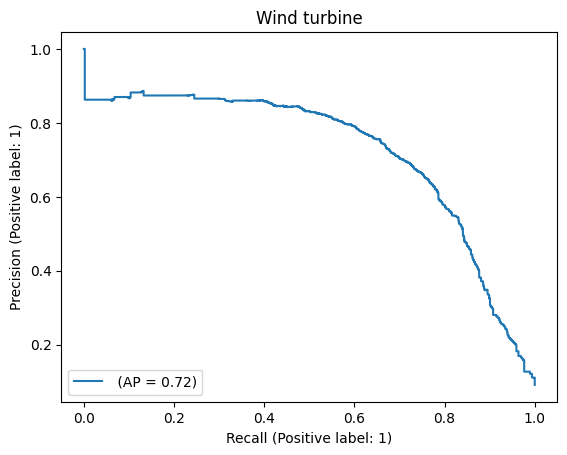

In [526]:
# plot individual precision-recall curve
class_number = 27

display = PrecisionRecallDisplay.from_estimator(
    multilabel_clf.estimators_[class_number], x_test, y_test[:,class_number], name=""
)
_ = display.ax_.set_title(id_to_text_mapper.iloc[class_number])

print(y_test[:,class_number].mean())
# print(id_to_text_mapper.iloc[0])


#### Performance tracker

In [387]:
# tracker = pd.DataFrame(index=id_to_text_mapper)

In [507]:
set_name = '1'

In [508]:
tracker[set_name] = avg_prec_scores
tracker

,0,1
improvement_id_text,,
Insulate hot water cylinder with 80 mm jacket,0.475,0.405
Increase hot water cylinder insulation,0.430,0.305
Add additional 80 mm jacket to hot water cylinder,0.233,0.247
Hot water cylinder thermostat,0.827,0.783
Increase loft insulation to 270 mm,0.300,0.367
Cavity wall insulation,0.351,0.492
50 mm internal or external wall insulation,0.827,0.847
Replace single glazed windows with low-E double glazing,0.990,0.984
Secondary glazing to single glazed windows,0.041,0.106


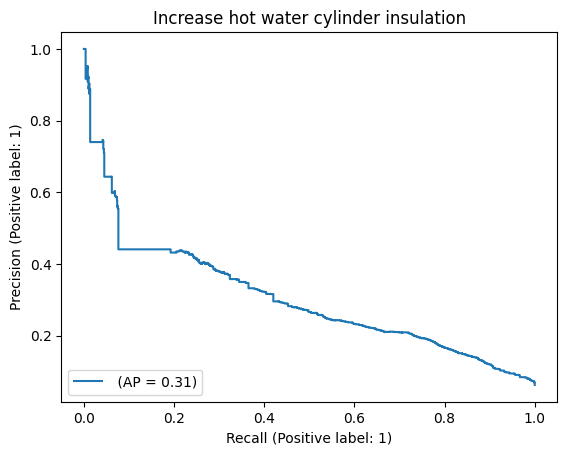

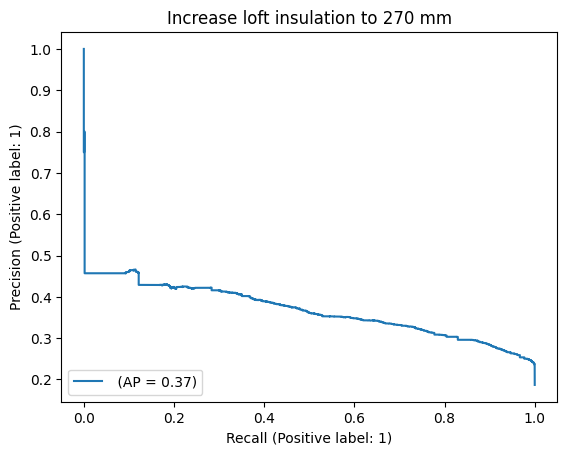

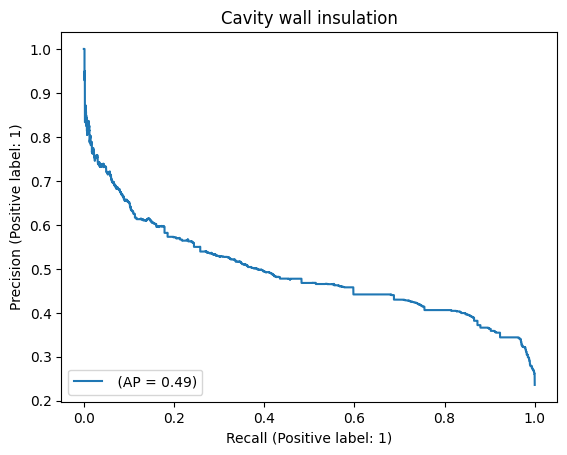

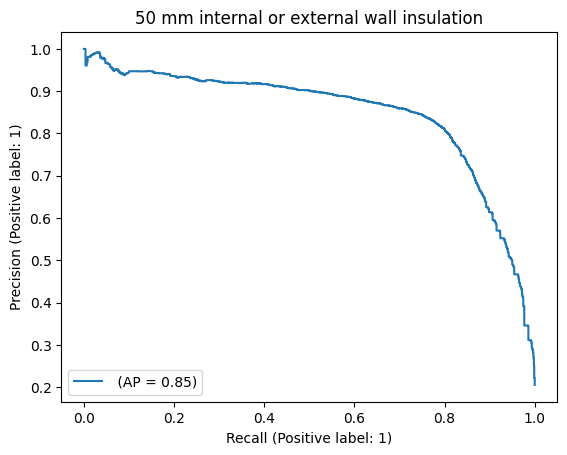

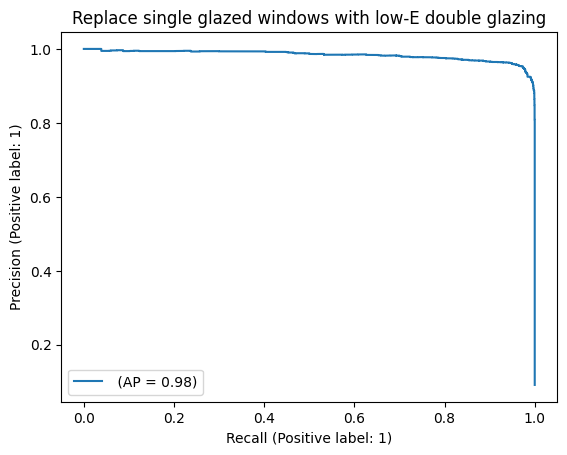

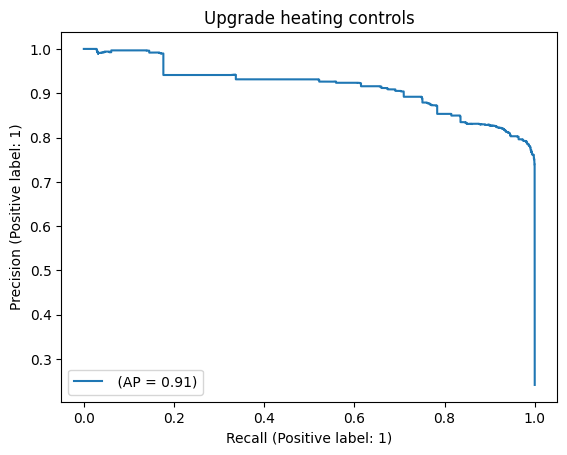

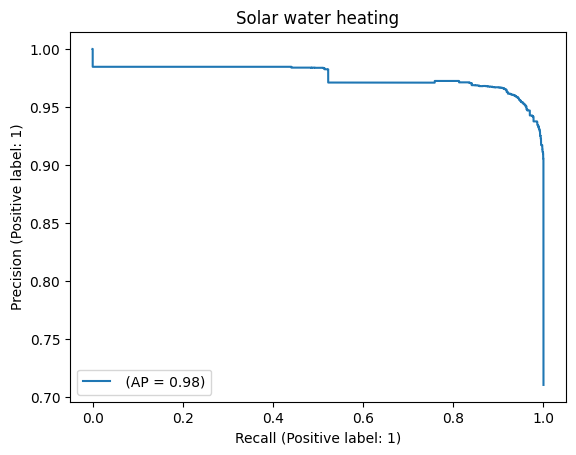

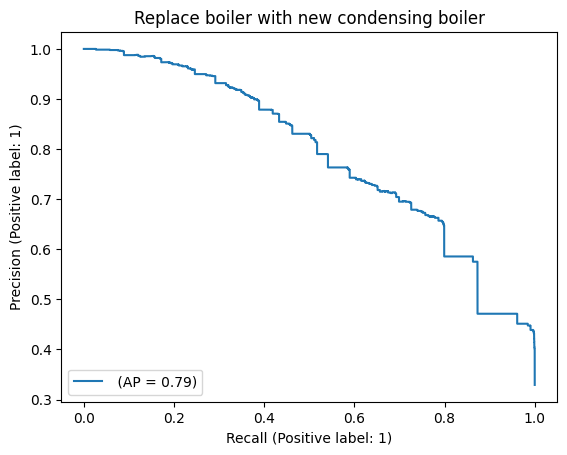

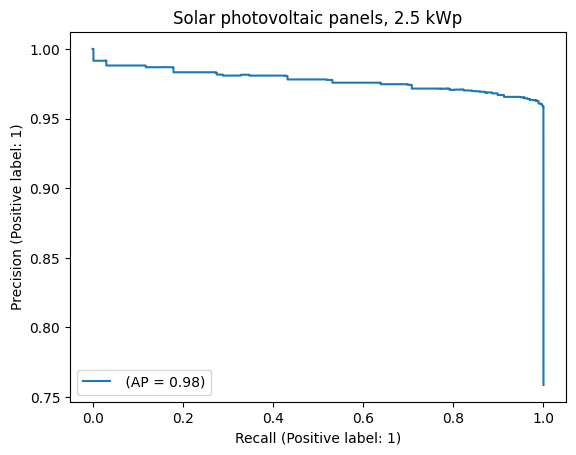

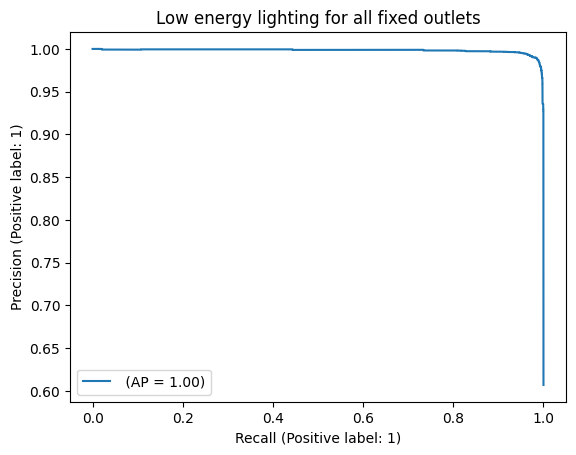

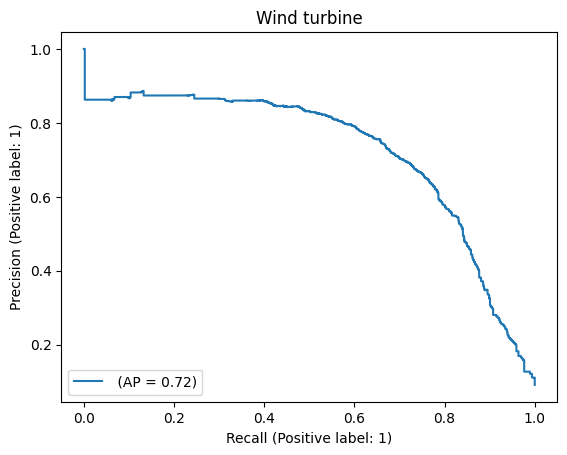

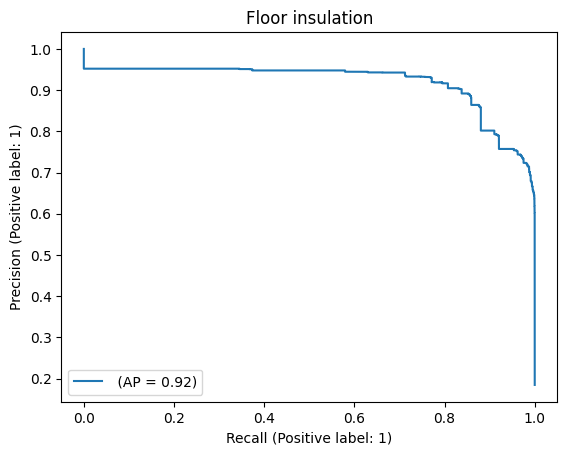

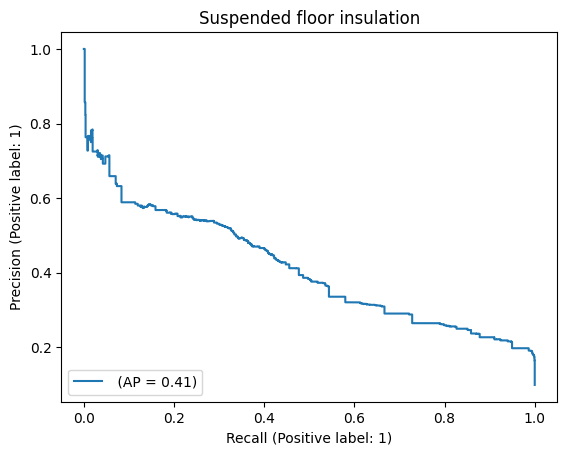

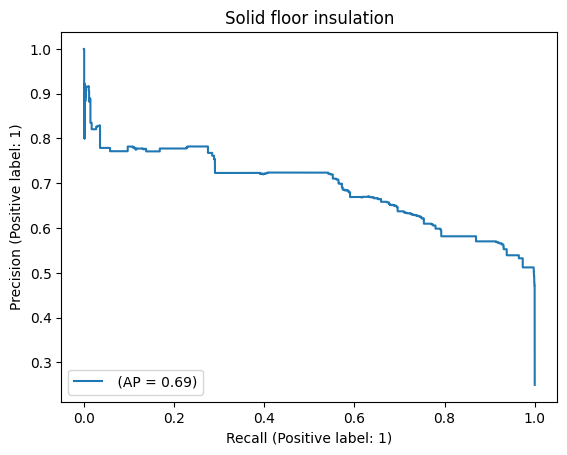

In [533]:
for class_number in range(len(id_to_text_mapper)):
    
    if y_test[:,class_number].mean() >= .05:
        
        
        # print(print(y_test[:,class_number].mean()))
        
        display = PrecisionRecallDisplay.from_estimator(
            multilabel_clf.estimators_[class_number], x_test, y_test[:,class_number], name=""
        )
        _ = display.ax_.set_title(id_to_text_mapper.iloc[class_number])

        # print()
        # print()
        # print(y_test[:,class_number].mean())
        # print(id_to_text_mapper.iloc[0])
